In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np
import torch
from torch import nn

In [2]:
class DataReader:
  def __init__(self):
    self.data = "Acknowledgement"
    chars = list(set(self.data))
    chars.append(" ")
    self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
    self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
    self.seq_length = len(self.data)
    self.vocab_size = len(chars)

  def get_inputs_targets(self, data):
   inputs_str = data
   target_str = data[1:]    
   target_str = target_str + " "
   inputs = [self.char_to_ix[ch] for ch in inputs_str] 
   targets = [self.char_to_ix[ch] for ch in target_str]
   return inputs, targets

datareader = DataReader()
input_seq, target_seq = datareader.get_inputs_targets(datareader.data)


In [3]:
dict_size = len(datareader.char_to_ix)
seq_len = datareader.seq_length
batch_size = 1

features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
for i in range(batch_size):
    for u in range(seq_len):
        features[i, u, input_seq[u]] = 1

input_seq = torch.from_numpy(features)
target_seq = torch.Tensor(target_seq)

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [5]:
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=5, n_layers=1)

n_epochs = 5000
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
losses = []
iterations = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() 
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()
    optimizer.step() 
    
    if epoch%250 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
        losses.append(loss.item())
        iterations.append(epoch)



Epoch: 250/5000............. Loss: 0.0760
Epoch: 500/5000............. Loss: 0.0231
Epoch: 750/5000............. Loss: 0.0118
Epoch: 1000/5000............. Loss: 0.0072
Epoch: 1250/5000............. Loss: 0.0048
Epoch: 1500/5000............. Loss: 0.0035
Epoch: 1750/5000............. Loss: 0.0026
Epoch: 2000/5000............. Loss: 0.0020
Epoch: 2250/5000............. Loss: 0.0016
Epoch: 2500/5000............. Loss: 0.0013
Epoch: 2750/5000............. Loss: 0.0010
Epoch: 3000/5000............. Loss: 0.0009
Epoch: 3250/5000............. Loss: 0.0007
Epoch: 3500/5000............. Loss: 0.0006
Epoch: 3750/5000............. Loss: 0.0005
Epoch: 4000/5000............. Loss: 0.0004
Epoch: 4250/5000............. Loss: 0.0004
Epoch: 4500/5000............. Loss: 0.0003
Epoch: 4750/5000............. Loss: 0.0003
Epoch: 5000/5000............. Loss: 0.0002


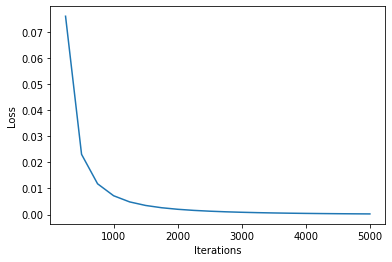

In [7]:
import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iterations, losses)

In [8]:
def predict(model, character):
    character = np.array([datareader.char_to_ix[c] for c in character])
    features = np.zeros((batch_size, len(character), dict_size), dtype=np.float32)
    for i in range(batch_size):
        for u in range(len(character)):
            features[i, u, character[u]] = 1    
    character = torch.from_numpy(features)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    char_ind = torch.max(prob, dim=0)[1].item()

    return datareader.ix_to_char[char_ind], hidden

In [9]:
start = "A"
seq_len = datareader.seq_length
model.eval()
chars = [ch for ch in start]
size = seq_len - len(chars)
i = 0
while i<size:
    char, h = predict(model, chars)
    chars.append(char)
    i+=1

print("Predicted: " + ''.join(chars))

Predicted: Acknowledgement
